# **강화학습 중간고사 시험 문제**
- 코드의 단계별로 작성하고 설명 작성하세요.
- 각각의 ipynb 파일로 제출하세요.
- 파일명 예시: **202500000 홍길동_Jack's Car rental.ipynb**

# 학번과 이름을 기입해주세요. (한글)

- 학번: 202192022
- 이름: 여명구

## **2. Jack's Car rental**

### 문제:
- 잭(Jack)은 두 곳의 렌트카 지점(A, B)을 운영하고 있음.
- 매일 밤 두 지점 간에 차량을 재배치하여 다음 날의 렌트 수익의 최대화하고 싶어함.
- **수익을 최대화하기 위해서 잭(Jack)은 어떻게 해야 하는가?**

### 조건
- 수익: 차량 1대를 렌트하면 $10의 수익이 발생합니다.

- 비용: 지점 간 차량 1대를 이동시키면 $2의 비용이 발생합니다.

- 제약
  1) 각 지점은 최대 20대의 차량만 보유할 수 있습니다. (초과분은 사라짐)
  2) 밤에 이동시킬 수 있는 차량은 최대 5대입니다.


※ 제출 내용
  1)  최적 정책 (시각화)
  2)  최적 가치 함수 (시각화)

In [1]:
'''
이 코드는 '잭의 렌터카(Jack's Car Rental)' 문제를 해결하기 위해
'정책 반복(Policy Iteration)' 알고리즘을 구현합니다.

이 문제는 PDF 자료에서 제시된 MDP(S, A, P, R) 정의를 따릅니다.
- S (상태): (A지점 차량 수, B지점 차량 수) [cite: 189]
- A (행동): A->B로 이동하는 차량 수 (-5 ~ +5) [cite: 192]
- P (전이): 수요/반납이 포아송 분포를 따름 [cite: 152, 202, 203]
- R (보상): 대여료($10) - 이동비용($2) [cite: 148]

알고리즘은 [정책 평가]와 [정책 개선]을 수렴할 때까지 반복합니다[cite: 221].
'''

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # 시각화를 위한 Seaborn 사용
from scipy.stats import poisson

# --- 1. 환경 및 문제 조건 설정 ---

# 제약 조건
MAX_CARS = 20           # 각 지점 최대 차량 수 [cite: 143]
MAX_MOVE = 5            # 밤 사이 최대 이동 가능 차량 수 [cite: 145]
STATE_SPACE = MAX_CARS + 1 # (0 ~ 20, 총 21개 상태)

# 보상 및 비용
RENTAL_PROFIT = 10      # 대여 수익 [cite: 148]
MOVE_COST = 2           # 이동 비용

# MDP 파라미터
GAMMA = 0.9             # 할인율 (PDF 예시) [cite: 217]

# PDF에서 가정한 포아송 분포 파라미터 [cite: 153, 154]
LAMBDA_REQ_1 = 3  # 1번 지점(A) 평균 요청
LAMBDA_RET_1 = 3  # 1번 지점(A) 평균 반납
LAMBDA_REQ_2 = 4  # 2번 지점(B) 평균 요청
LAMBDA_RET_2 = 2  # 2번 지점(B) 평균 반납

# 계산 최적화: 포아송 분포는 꼬리가 길기 때문에
# 확률이 매우 낮은 (e.g., 11대 이상) 경우는 계산에서 제외 [cite: 211]
MAX_POISSON_K = 11      
# 포아송 확률값 캐시 (매번 계산하는 것을 방지)
poisson_cache = dict()

def get_poisson_prob(k, lam):
    """
    k와 lambda에 대한 포아송 확률(PMF)을 계산합니다.
    (계산된 값을 캐시에 저장하여 중복 계산 방지)
    """
    if (k, lam) not in poisson_cache:
        poisson_cache[(k, lam)] = poisson.pmf(k, lam)
    return poisson_cache[(k, lam)]

# --- 2. 핵심 함수: 기대 보상 계산 (4중 루프) ---

def calculate_expected_return(state, action, V):
    """
    현재 상태(s), 행동(a), 현재 가치함수(V)를 바탕으로
    벨만 방정식의 우변(기대 보상 + 기대 가치)을 계산합니다.
    이것이 이 문제의 가장 복잡한 '전이(P)'와 '보상(R)' 부분입니다.
    """
    
    # 1. 즉각적인 보상(비용)
    # 행동(action)은 1->2로 옮기는 차의 수.
    expected_return = -MOVE_COST * abs(action)
    
    # 2. 행동(a) 적용 후 아침 차량 대수
    # (제약 조건 1: 최대 20대)
    n1_start = min(state[0] - action, MAX_CARS)
    n2_start = min(state[1] + action, MAX_CARS)

    # 3. 모든 확률적 사건(수요/반납)에 대한 기댓값 계산 (4중 루프)
    for req1 in range(MAX_POISSON_K):
        for req2 in range(MAX_POISSON_K):
            for ret1 in range(MAX_POISSON_K):
                for ret2 in range(MAX_POISSON_K):
                    
                    # 4. 이 사건이 발생할 확률 (P)
                    # 모든 사건은 독립적이므로 확률을 곱함 [cite: 204]
                    prob = (
                        get_poisson_prob(req1, LAMBDA_REQ_1) *
                        get_poisson_prob(req2, LAMBDA_REQ_2) *
                        get_poisson_prob(ret1, LAMBDA_RET_1) *
                        get_poisson_prob(ret2, LAMBDA_RET_2)
                    )
                    
                    # 5. 실제 렌트된 차량 수 (수요가 재고보다 많을 수 없음)
                    rented1 = min(n1_start, req1)
                    rented2 = min(n2_start, req2)
                    
                    # 6. 확률적 보상 (R)
                    profit = (rented1 + rented2) * RENTAL_PROFIT
                    
                    # 7. 하루 종료 시 차량 수 (다음 상태 s')
                    # (제약 조건 1: 최대 20대) [cite: 207]
                    n1_end = min(n1_start - rented1 + ret1, MAX_CARS)
                    n2_end = min(n2_start - rented2 + ret2, MAX_CARS)
                    
                    # 8. E[R + γV(s')] 누적
                    # (V[n1_end, n2_end]는 다음 상태의 가치)
                    expected_return += prob * (profit + GAMMA * V[n1_end, n2_end])

    return expected_return

# --- 3. 알고리즘: 정책 반복 (Policy Iteration) ---

def policy_iteration():
    """
    정책 반복(Policy Iteration)을 수행하여
    최적 정책(Policy)과 최적 가치(V)를 찾습니다.
    """
    
    # 1. 초기화
    # V: 21x21 크기, 0으로 초기화
    V = np.zeros((STATE_SPACE, STATE_SPACE)) 
    # Policy: 21x21 크기, 0으로 초기화 (행동: "이동 안 함")
    Policy = np.zeros((STATE_SPACE, STATE_SPACE), dtype=int) 
    
    iteration = 0
    while True:
        iteration += 1
        print(f"\n===== [정책 반복 Iteration {iteration}] =====")
        
        # --- [STEP 1: 정책 평가 (Policy Evaluation)] ---
        # 현재 정책(Policy)이 얼마나 좋은지, V가 수렴할 때까지 계산 [cite: 222]
        print("1. 정책 평가 (Policy Evaluation) 시작...")
        while True:
            delta = 0
            # V(k+1) 계산을 위해 V(k)를 복사
            V_old = V.copy() 
            
            # 441개 모든 상태(s)에 대해
            for n1 in range(STATE_SPACE):
                for n2 in range(STATE_SPACE):
                    state = (n1, n2)
                    # 현재 정책(Policy)이 정해준 행동(a)
                    action = Policy[state] 
                    
                    # V(k+1)[s] <- E[R + γV(k)[s']]
                    V[state] = calculate_expected_return(state, action, V_old)
                    
                    delta = max(delta, abs(V[state] - V_old[state]))
            
            print(f"   V 가치 최대 변화량(delta): {delta:.4f}")
            # 가치 함수가 수렴하면 평가 종료
            if delta < 1e-4: # (수렴 기준값)
                print("   정책 평가 완료. V 수렴.")
                break

        # --- [STEP 2: 정책 개선 (Policy Improvement)] ---
        # 계산된 V를 바탕으로 더 나은 행동이 있는지 탐색 [cite: 223]
        print("2. 정책 개선 (Policy Improvement) 시작...")
        policy_stable = True
        
        for n1 in range(STATE_SPACE):
            for n2 in range(STATE_SPACE):
                state = (n1, n2)
                old_action = Policy[state]
                
                action_returns = []
                
                # 제약 2)를 고려한 가능한 모든 행동 (-5 ~ +5)
                # (단, 현재 재고를 초과할 수 없음)
                valid_actions = range(
                    max(-MAX_MOVE, -n2),               # B에서 5대 or n2대 이상 못 뺌
                    min(MAX_MOVE, n1) + 1              # A에서 5대 or n1대 이상 못 뺌
                )
                
                # 모든 가능한 행동 'a'에 대해
                for action in valid_actions:
                    # Q(s, a) = E[R + γV(s')] 계산
                    q_value = calculate_expected_return(state, action, V)
                    action_returns.append(q_value)
                
                # 가장 좋은(Greedy) 행동을 새 정책으로 선택
                new_action = valid_actions[np.argmax(action_returns)]
                Policy[state] = new_action
                
                # 정책이 하나라도 바뀌었는지 확인
                if old_action != new_action:
                    policy_stable = False
        
        if policy_stable:
            print(f"정책 개선 완료. 정책이 안정됨(Stable).")
            print(f"===== [최적 정책 발견! Iteration {iteration}에서 종료] =====")
            break # 메인 루프 종료
        else:
            print(f"정책 개선 완료. 정책이 변경됨(Unstable).")

    return Policy, V

# --- 4. 시각화 함수 ---

def plot_results(Policy, V):
    """
    최종 최적 정책(π*)과 최적 가치(V*)를 시각화합니다.
    """
    
    # 플롯 1: 최적 가치 함수 (V*) - 3D 표면 플롯
    # (PDF 12페이지의 V4 그래프와 유사 [cite: 179])
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(111, projection='3d')
    X = np.arange(0, STATE_SPACE) # Loc 2 (0~20)
    Y = np.arange(0, STATE_SPACE) # Loc 1 (0~20)
    X, Y = np.meshgrid(X, Y)
    
    # (V 배열의 (n1, n2) 축이 (Y, X)와 일치함)
    ax.plot_surface(X, Y, V, cmap='viridis')
    ax.set_title('Optimal Value Function (V*)')
    ax.set_xlabel('# Cars at Location 2')
    ax.set_ylabel('# Cars at Location 1')
    ax.set_zlabel('Expected Return ($)')
    plt.show()

    # 플롯 2: 최적 정책 (π*) - 2D 히트맵
    # (PDF 12페이지의 π4 그래프와 유사 [cite: 169])
    plt.figure(figsize=(10, 8))
    # (정책 배열을 뒤집어야 (0,0)이 좌하단에 옴)
    Policy_flipped = np.flipud(Policy) 
    
    ax = sns.heatmap(
        Policy_flipped, 
        cmap='coolwarm',  # (양수: A->B(파랑), 음수: B->A(빨강))
        center=0,         # 0을 흰색으로
        annot=True,       # 숫자 표시
        fmt='d',          # 정수로
        linewidths=.5
    )
    ax.set_title('Optimal Policy (π*) [Cars moved from Loc 1 to Loc 2]')
    ax.set_xlabel('# Cars at Location 2')
    ax.set_ylabel('# Cars at Location 1')
    # Y축 레이블을 (0, 5, ..., 20)으로 수정 (뒤집었기 때문)
    ax.set_yticklabels(
        np.arange(MAX_CARS, -1, -5), 
        rotation=0, 
        va='center'
    )
    ax.set_xticklabels(np.arange(0, STATE_SPACE, 5))
    plt.show()


# --- 5. 메인 실행 ---
if __name__ == "__main__":
    
    print("===== [잭의 렌터카 문제 풀이 시작] =====")
    print("알고리즘: 정책 반복 (Policy Iteration)")
    print(f"가정: γ={GAMMA}, λ(req1,ret1)=({LAMBDA_REQ_1},{LAMBDA_RET_1}), λ(req2,ret2)=({LAMBDA_REQ_2},{LAMBDA_RET_2})\n")
    
    # 1. 문제 풀이
    optimal_policy, optimal_value = policy_iteration()
    
    # 2. 결과 출력 (중요 요소 확인)
    print("\n\n--- [제출 1] 최적 정책 (π*) ---")
    print("(각 칸은 (A지점 차량, B지점 차량) 상태에서 A->B로 이동시킬 차량 수)")
    print(optimal_policy)
    
    print("\n\n--- [제출 2] 최적 가치 함수 (V*) ---")
    print("(각 칸은 해당 상태의 총 기대 수익)")
    print(optimal_value.round(1))
    
    # 3. 결과 시각화
    print("\n\n--- [시각화] 결과 플롯 생성 중 ---")
    plot_results(optimal_policy, optimal_value)
    
    print("===== [문제 풀이 완료] =====")

c:\Users\brigh\Documents\GitHub\warehouse\.venv\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.stats import gaussian_kde


===== [잭의 렌터카 문제 풀이 시작] =====
알고리즘: 정책 반복 (Policy Iteration)
가정: γ=0.9, λ(req1,ret1)=(3,3), λ(req2,ret2)=(4,2)


===== [정책 반복 Iteration 1] =====
1. 정책 평가 (Policy Evaluation) 시작...
   V 가치 최대 변화량(delta): 69.5240
   V 가치 최대 변화량(delta): 62.3569
   V 가치 최대 변화량(delta): 55.9161
   V 가치 최대 변화량(delta): 49.9777
   V 가치 최대 변화량(delta): 44.2147
   V 가치 최대 변화량(delta): 38.5643
   V 가치 최대 변화량(delta): 33.2485
   V 가치 최대 변화량(delta): 28.5103
   V 가치 최대 변화량(delta): 24.4605
   V 가치 최대 변화량(delta): 21.0821
   V 가치 최대 변화량(delta): 18.2882
   V 가치 최대 변화량(delta): 15.9723
   V 가치 최대 변화량(delta): 14.0354
   V 가치 최대 변화량(delta): 12.3964
   V 가치 최대 변화량(delta): 10.9925
   V 가치 최대 변화량(delta): 9.7771
   V 가치 최대 변화량(delta): 8.7153
   V 가치 최대 변화량(delta): 7.7813
   V 가치 최대 변화량(delta): 6.9552
   V 가치 최대 변화량(delta): 6.2219
   V 가치 최대 변화량(delta): 5.5691
   V 가치 최대 변화량(delta): 4.9869
   V 가치 최대 변화량(delta): 4.4668
   V 가치 최대 변화량(delta): 4.0018
   V 가치 최대 변화량(delta): 3.5858
   V 가치 최대 변화량(delta): 3.2135
   V 가치 최대 변화량(delta): 2.

KeyboardInterrupt: 

c:\Users\brigh\Documents\GitHub\warehouse\.venv\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.stats import gaussian_kde


포아송 확률 테이블 계산 중... 완료.
--- Initial State (Iter 0) ---


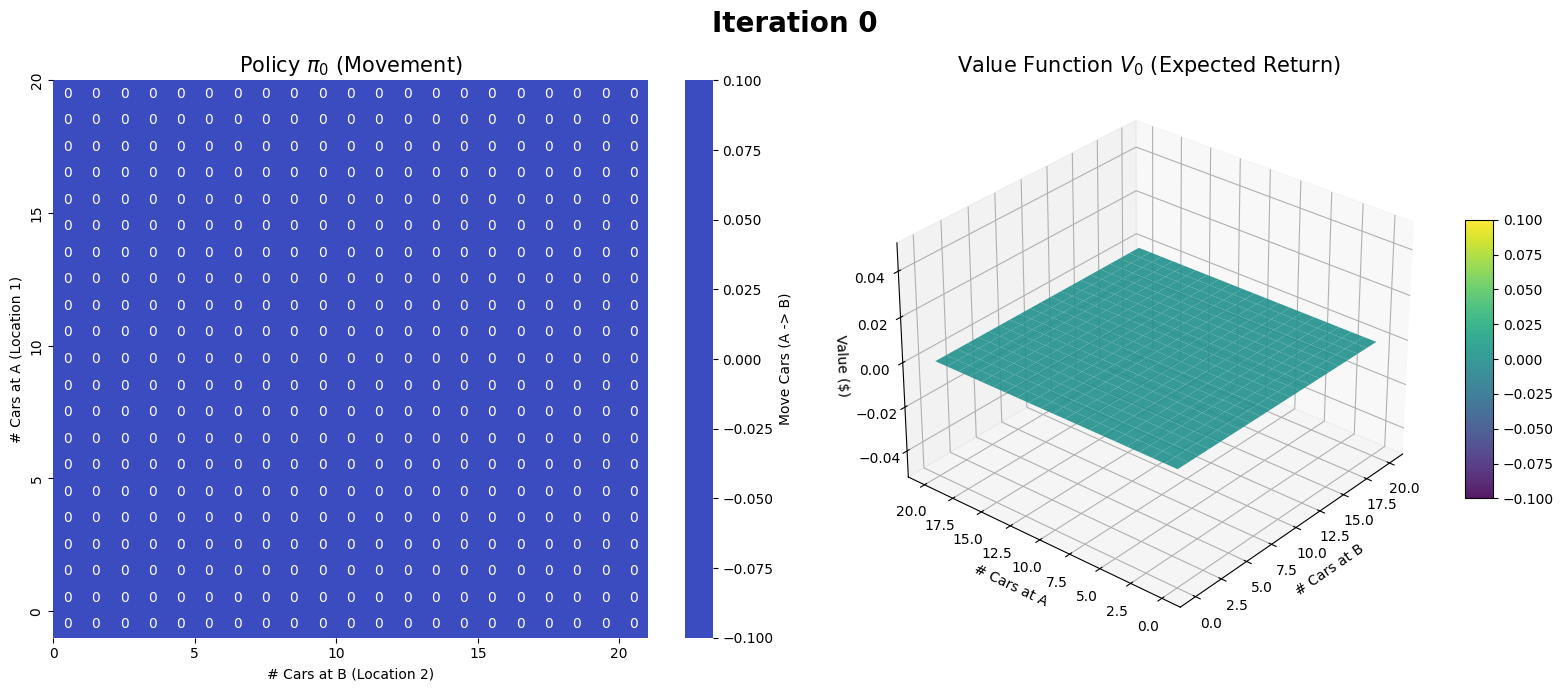


========== Iteration 1 ==========
1. Policy Evaluation (가치 함수 계산 중...)
   Delta: 0.0841 -> Converged!
2. Policy Improvement (정책 업데이트 중...)


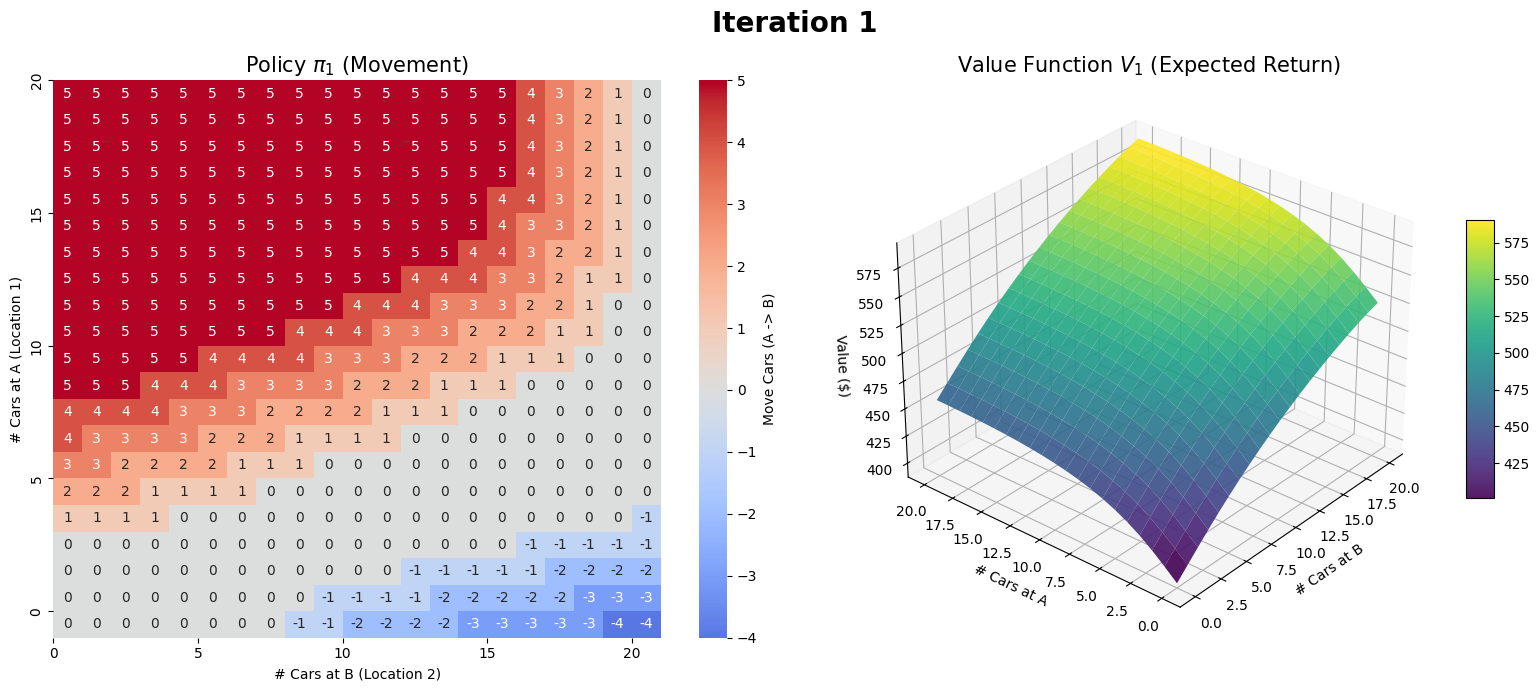


========== Iteration 2 ==========
1. Policy Evaluation (가치 함수 계산 중...)
   Delta: 0.0935 -> Converged!
2. Policy Improvement (정책 업데이트 중...)


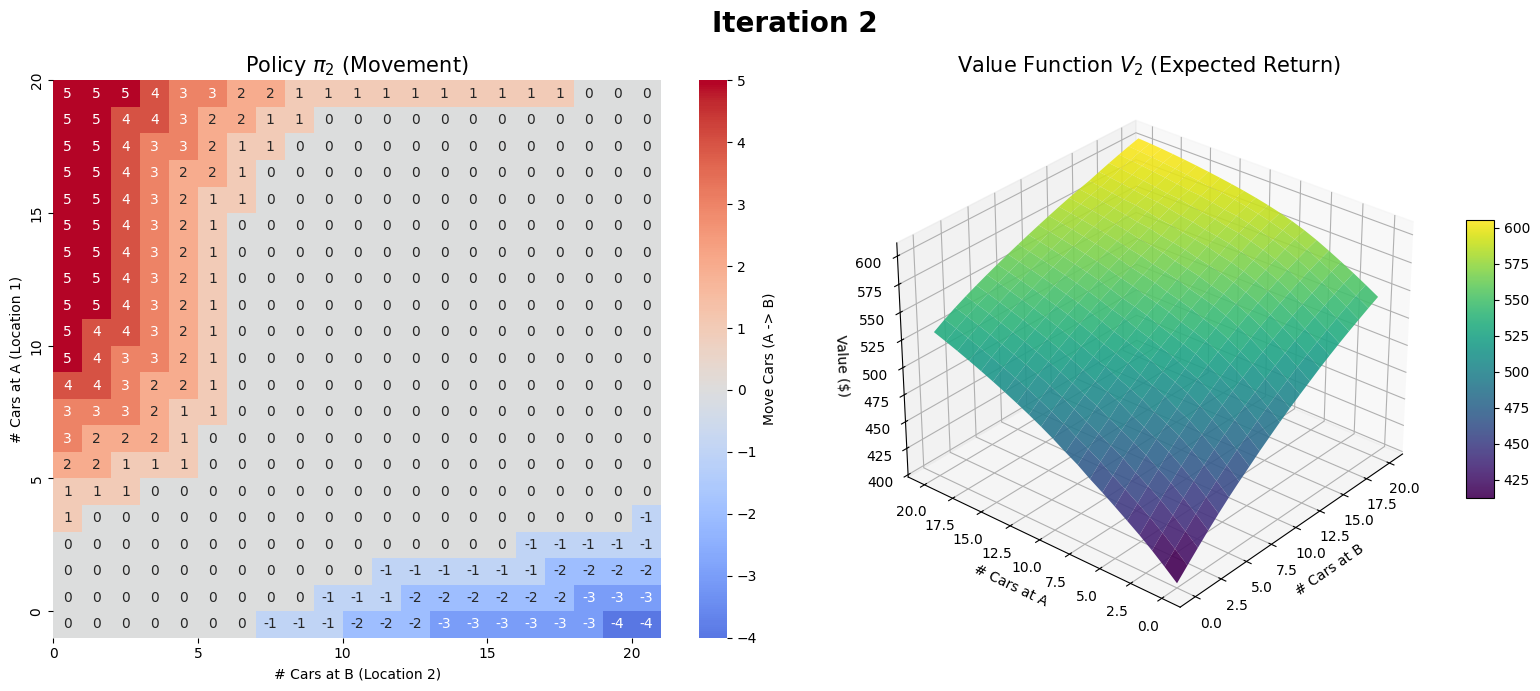


========== Iteration 3 ==========
1. Policy Evaluation (가치 함수 계산 중...)
   Delta: 0.0825 -> Converged!
2. Policy Improvement (정책 업데이트 중...)


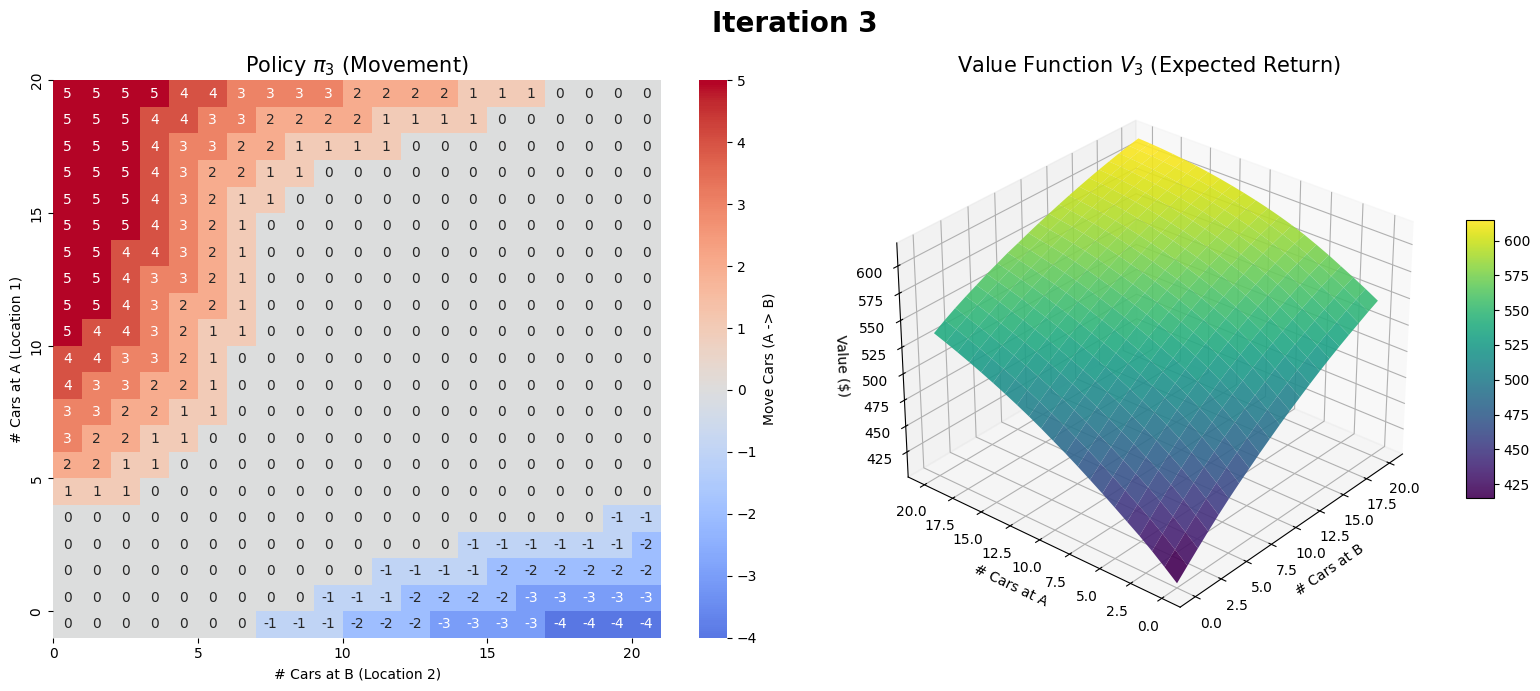


========== Iteration 4 ==========
1. Policy Evaluation (가치 함수 계산 중...)
   Delta: 0.0673 -> Converged!
2. Policy Improvement (정책 업데이트 중...)


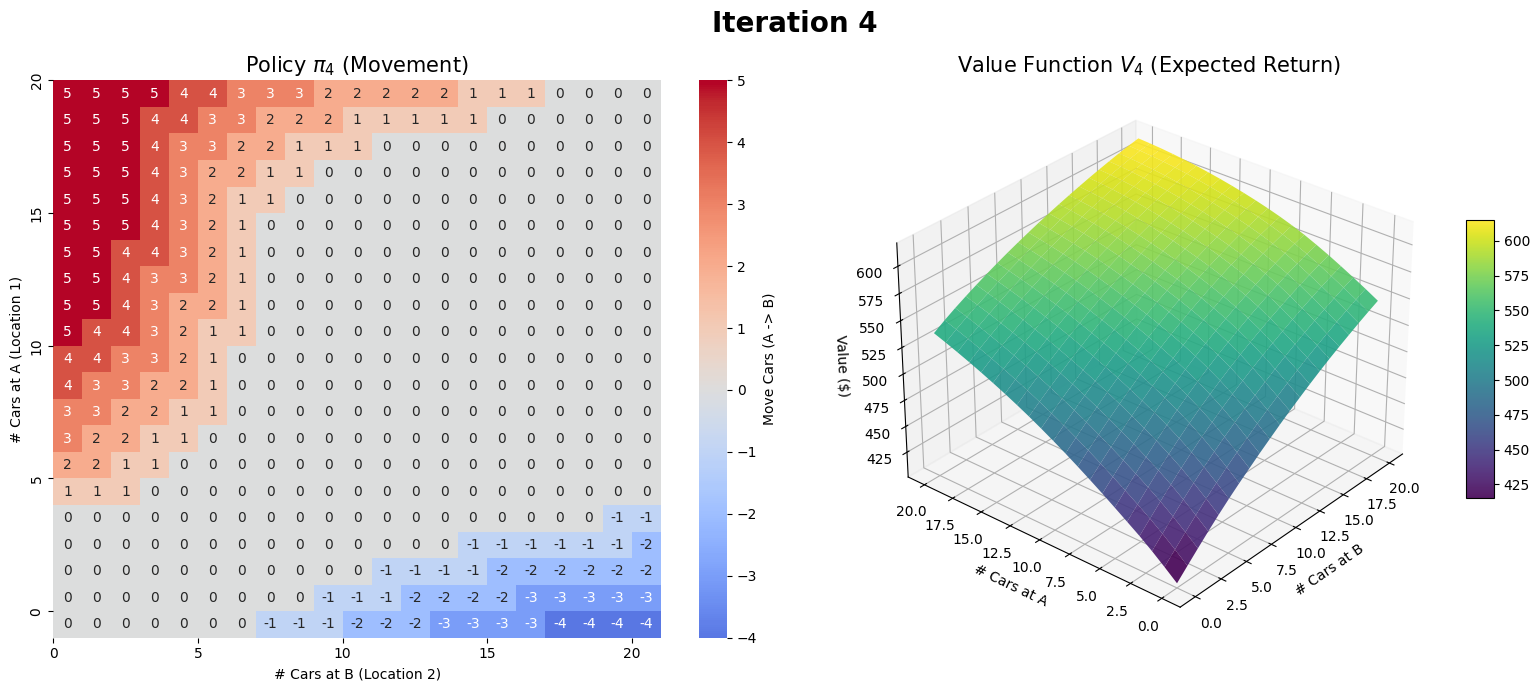


========== Iteration 5 ==========
1. Policy Evaluation (가치 함수 계산 중...)
   Delta: 0.0630 -> Converged!
2. Policy Improvement (정책 업데이트 중...)


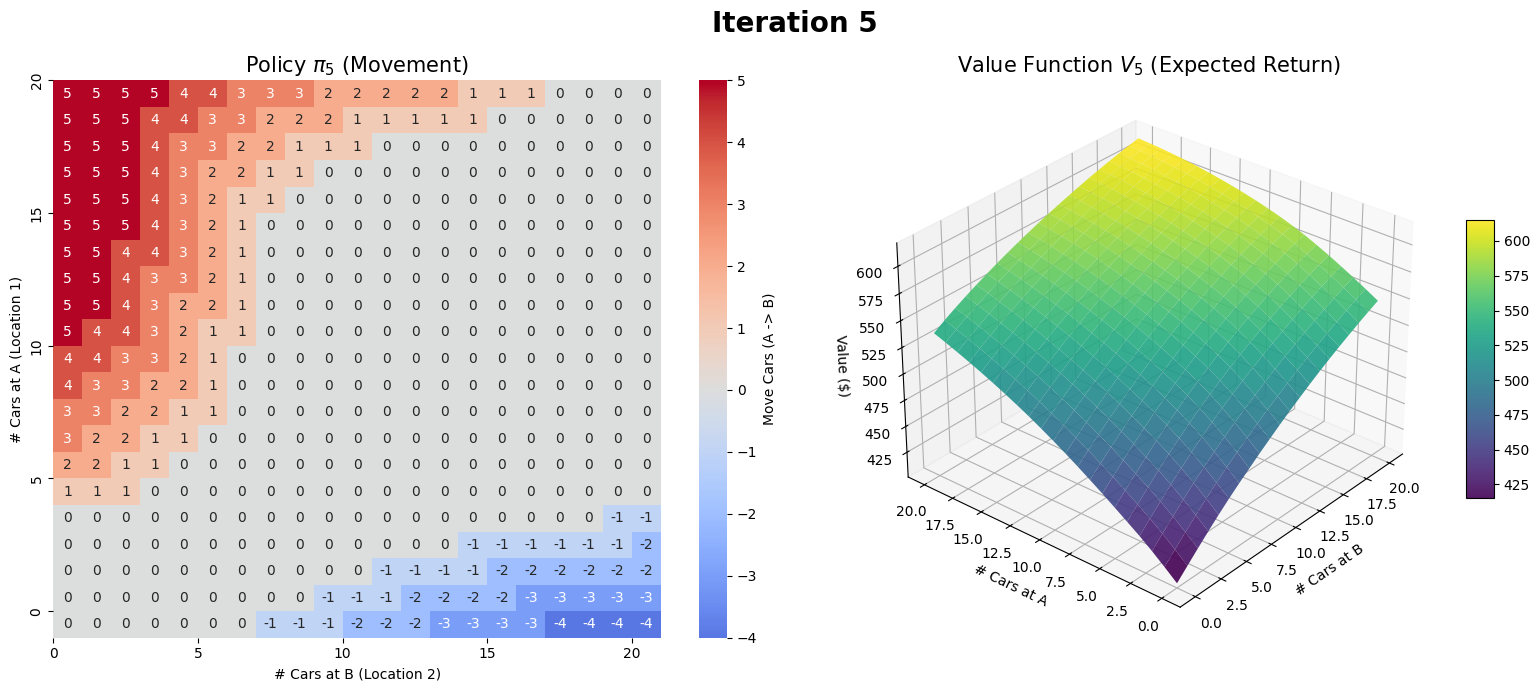


🎉 최적 정책을 찾았습니다!


In [1]:
'''
잭의 렌터카 문제 (Policy Iteration)
- 특징: 매 Iteration마다 현재의 정책(Policy)과 가치(Value)를 시각화합니다.
- 최적화: 포아송 확률을 미리 계산(Pre-compute)하여 속도를 높였습니다.
'''

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from mpl_toolkits.mplot3d import Axes3D

# --- 1. 환경 설정 (Constants) ---
MAX_CARS = 20           # 최대 차량 수
MAX_MOVE = 5            # 최대 이동 수
RENTAL_CREDIT = 10      # 대여 수익 ($10)
MOVE_COST = 2           # 이동 비용 ($2)
GAMMA = 0.9             # 할인율

# 포아송 분포 파라미터 (Lambda)
LAMBDA_RENT_A = 3
LAMBDA_RETURN_A = 3
LAMBDA_RENT_B = 4
LAMBDA_RETURN_B = 2

# 계산 속도를 위해 확률이 거의 0인 지점까지만 계산 (Truncation)
POISSON_UPPER_BOUND = 11 

# --- 2. 포아송 확률 미리 계산 (Pre-computation) ---
# 루프 안에서 매번 pmf를 부르면 매우 느리므로 미리 계산해 둡니다.
poisson_cache = {}

def precompute_poisson():
    print("포아송 확률 테이블 계산 중...", end="")
    for n in range(POISSON_UPPER_BOUND):
        poisson_cache[('rent_A', n)] = poisson.pmf(n, LAMBDA_RENT_A)
        poisson_cache[('ret_A', n)]  = poisson.pmf(n, LAMBDA_RETURN_A)
        poisson_cache[('rent_B', n)] = poisson.pmf(n, LAMBDA_RENT_B)
        poisson_cache[('ret_B', n)]  = poisson.pmf(n, LAMBDA_RETURN_B)
    print(" 완료.")

# --- 3. 시각화 함수 (매 Iteration마다 호출) ---
def plot_iteration_results(k, policy, value):
    """
    k번째 Iteration의 정책과 가치함수를 시각화합니다.
    """
    fig = plt.figure(figsize=(16, 7))
    fig.suptitle(f"Iteration {k}", fontsize=20, weight='bold')

    # [왼쪽] 정책 (Policy) 히트맵
    ax1 = fig.add_subplot(1, 2, 1)
    
    # (0,0)이 그래프의 좌측 하단에 오도록 배열을 뒤집음(flipud)
    sns.heatmap(np.flipud(policy), cmap='coolwarm', center=0, annot=True, fmt='d',
                cbar_kws={'label': 'Move Cars (A -> B)'}, ax=ax1)
    
    ax1.set_title(f"Policy $\pi_{k}$ (Movement)", fontsize=15)
    ax1.set_xlabel("# Cars at B (Location 2)")
    ax1.set_ylabel("# Cars at A (Location 1)")
    
    # Y축 레이블 수정 (20, 15, ..., 0 순서로 표시됨)
    ticks = np.arange(0, MAX_CARS + 1, 5)
    ax1.set_yticks(ticks)
    ax1.set_yticklabels(ticks[::-1]) # 뒤집힌 레이블
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(ticks)

    # [오른쪽] 가치 함수 (Value) 3D 플롯
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    x = np.arange(MAX_CARS + 1)
    y = np.arange(MAX_CARS + 1)
    X, Y = np.meshgrid(x, y)
    
    # 표면 플롯
    surf = ax2.plot_surface(X, Y, value, cmap='viridis', edgecolor='none', alpha=0.9)
    
    ax2.set_title(f"Value Function $V_{k}$ (Expected Return)", fontsize=15)
    ax2.set_xlabel("# Cars at B")
    ax2.set_ylabel("# Cars at A")
    ax2.set_zlabel("Value ($)")
    ax2.view_init(elev=30, azim=220) # 보기 좋은 각도로 설정
    fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=10)

    plt.tight_layout()
    plt.show()

# --- 4. 기대 가치 계산 엔진 ---
def expected_return(state, action, V):
    """
    상태 s에서 행동 a를 했을 때의 기대 가치를 계산 (Bellman Equation 우변)
    """
    returns = -MOVE_COST * abs(action) # 이동 비용 (음수)
    
    # 이동 후 아침 재고 (최대 20대 제한)
    n_A = min(state[0] - action, MAX_CARS)
    n_B = min(state[1] + action, MAX_CARS)
    
    # 4중 루프: (A대여 x B대여 x A반납 x B반납)
    # 확률이 유의미한 구간(POISSON_UPPER_BOUND)까지만 반복
    for rent_A in range(POISSON_UPPER_BOUND):
        prob_rent_A = poisson_cache[('rent_A', rent_A)]
        
        for rent_B in range(POISSON_UPPER_BOUND):
            prob_rent_B = poisson_cache[('rent_B', rent_B)]
            
            # 실제 대여 수 (재고보다 많이 빌릴 순 없음)
            real_rent_A = min(n_A, rent_A)
            real_rent_B = min(n_B, rent_B)
            
            # 대여 수익 발생
            reward = (real_rent_A + real_rent_B) * RENTAL_CREDIT
            
            # (최적화) 현재 루프에서의 공통 확률과 보상
            prob_rent = prob_rent_A * prob_rent_B
            
            for ret_A in range(POISSON_UPPER_BOUND):
                prob_ret_A = poisson_cache[('ret_A', ret_A)]
                
                for ret_B in range(POISSON_UPPER_BOUND):
                    prob_ret_B = poisson_cache[('ret_B', ret_B)]
                    
                    # 전체 확률 (독립사건)
                    prob = prob_rent * prob_ret_A * prob_ret_B
                    
                    # 저녁 최종 재고 (다음 상태 s')
                    next_A = min(n_A - real_rent_A + ret_A, MAX_CARS)
                    next_B = min(n_B - real_rent_B + ret_B, MAX_CARS)
                    
                    # 기대 가치 누적
                    returns += prob * (reward + GAMMA * V[next_A, next_B])
                    
    return returns

# --- 5. 메인 알고리즘: 정책 반복 ---
def policy_iteration():
    # 초기화
    value_table = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    policy_table = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)
    
    iteration = 0
    
    # [0번째 상태 시각화] (아무것도 안 한 상태)
    print(f"--- Initial State (Iter 0) ---")
    plot_iteration_results(0, policy_table, value_table)

    while True:
        iteration += 1
        print(f"\n========== Iteration {iteration} ==========")
        
        # 1) 정책 평가 (Policy Evaluation)
        print("1. Policy Evaluation (가치 함수 계산 중...)")
        while True:
            old_value = value_table.copy()
            delta = 0
            
            # 모든 상태에 대해 V 업데이트
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    action = policy_table[i, j]
                    value_table[i, j] = expected_return([i, j], action, value_table)
                    delta = max(delta, abs(old_value[i, j] - value_table[i, j]))
            
            # 수렴 체크
            print(f"\r   Delta: {delta:.4f}", end="")
            if delta < 1e-1: # (속도를 위해 0.1로 완화, 정밀하게 하려면 1e-4)
                print(" -> Converged!")
                break
        
        # 2) 정책 개선 (Policy Improvement)
        print("2. Policy Improvement (정책 업데이트 중...)")
        policy_stable = True
        
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                old_action = policy_table[i, j]
                
                action_returns = []
                # 가능한 행동 범위: -5 ~ +5 (단, 보유 차량 수 고려)
                # A->B로 보내려면(양수) A에 차가 있어야 함 (i >= action)
                # B->A로 보내려면(음수) B에 차가 있어야 함 (j >= -action)
                min_action = max(-MAX_MOVE, -j)
                max_action = min(MAX_MOVE, i)
                actions = range(min_action, max_action + 1)
                
                for action in actions:
                    action_returns.append(expected_return([i, j], action, value_table))
                
                # Greedy하게 선택
                best_action_idx = np.argmax(action_returns)
                new_action = actions[best_action_idx]
                
                policy_table[i, j] = new_action
                
                if old_action != new_action:
                    policy_stable = False
        
        # 3) 시각화 (이번 Iteration 결과 출력)
        plot_iteration_results(iteration, policy_table, value_table)
        
        if policy_stable:
            print("\n🎉 최적 정책을 찾았습니다!")
            break

# --- 실행 ---
if __name__ == "__main__":
    precompute_poisson()
    policy_iteration()